# Analysing the wokeness of the film industry

### ___Study of the representation of ethnic diversity in the film industry___
This notebook resumes the work and data-pipeline achieved for Milestone 3, Milestone 2 is not provided in this notebook. 

The beginning of this Notebook consists of data processing and lodgin and extract the main figures which were asked to analyse in the feedback of milestone 2. The rest addresses a deeper analysis on the datasets. 

# Table of contents
1. [Libraries](#introduction)
2. [Importation datasets](#paragraph1)
    1. [Importation of the character dataset](#subparagraph1)
    2. [Importation of the movie dataset](#subparagraph2)
    3. [Merging the two datasets](#subparagraph3)
2. [Data overview](#paragraph2)
    1. [Number of movies over time](#subparagraph1)
    2. [Importation of the movie dataset](#subparagraph2)
    3. [Merging the two datasets](#subparagraph3)
3. [How is ethnic diversity represented in each country's film industry?](#paragraph3)
    1. [China](#subparagraph1)
    2. [United State of America](#subparagraph2) 
    3. [India](#subparagraph3)
    4. [Europe](#subparagraph4)
       1. [UK](#subsubparagraph1)
       2. [France](#subsubparagraph2)
       3. [Germany](#subsubparagraph3)
    5. [Top 100 movies](#subparagraph5)
    6. [Interactive plot](#subparagraph6)
4. [Diversity score](#paragraph4)
    1. [Entropy](#subparagraph1)
    1. [Simpson index](#subparagraph2)
       1. [Bootstrap resampling](#subsubparagraph1)
       2. [Heatmap of p_value](#subsubparagraph2)
5. [Correlation between success and actors diversity](#paragraph5)
   1. [Obsertionnal study](#subparagraph1)
   2. [Linear regression](#subparagraph2)
6. [Correlation between gender and actors diversity](#paragraph6)
   1. [Gender proportion vizualization](#subparagraph1)
   2. [t_test](#subparagraph2)
7. [Sentimental analysis](#paragraph7)
   1. [Score on summary](#subparagraph1)
   2. [Linear regression](#subparagraph2)

# 1. Libraries <a name="introduction"></a>

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import ast
from datetime import datetime
from country_list import countries_for_language
countries_list = dict(countries_for_language('en'))

#statistical testing
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scikits.bootstrap as boot
from statsmodels.stats import diagnostic
from scipy import stats

#Path
data_folder = './data/'

# 2. Importation datasets <a name="paragraph1"></a>

## A. Importation of the character dataset <a name="subparagraph1"></a>

In this project, we are going to work on the representation of the ethnicity on movies from different datas. We have approximately 450 000 characters aligned in the file `'character.metadata.tsv'` which datas are extracted from November 4 2012 , dump of freebase. It is the main data that we are going to use, as it contains the ID of the ethnicity. We are only going to keep 9 features, as the ohter features are no usefull for our analyses. We will also drop the character with unspecified ethnicity. Data after 2011 will be removed as our datas are extracted from 1920 to 2012 and we don't have enough movies for 2012 (see Milestone2 notebook). 

In [181]:
data1 = pd.read_csv(data_folder + 'character.metadata.tsv', sep='\t', header=None)

def format_attr(df):
     '''
     Create a new dataframe with all attributes
     formatted according to the character data set'
     :param dataframe: pandas.DataFrame
     :return: new dataframe
     '''
     formatted_df = pd.DataFrame()
     formatted_df['wikipedia_id'] = df[df.columns[0]].astype(int)
     formatted_df['freebase_movie_id'] = df[df.columns[1]].astype(str)
    
     formatted_df['date'] = df[df.columns[2]]
     formatted_df['date'] = pd.to_datetime(formatted_df['date'])
     formatted_df['date'] = pd.DatetimeIndex(formatted_df['date']).year
    
     formatted_df['character_name'] = df[df.columns[3]].astype(str)
     formatted_df['gender'] = df[df.columns[5]].astype(str)
     formatted_df['ethnicity'] = df[df.columns[7]].astype(str)
     formatted_df['name'] = df[df.columns[8]].astype(str, errors='ignore')
     formatted_df['age'] = df[df.columns[9]].astype(int, errors='ignore')
     formatted_df['freebase_actor_character_id'] = df[df.columns[10]].astype(str)
     formatted_df['freebase_actor_id'] = df[df.columns[12]].astype(str)
     formatted_df['freebase_character_id'] = df[df.columns[11]].astype(str)
        
     return formatted_df

data1 =  data1[data1[data1.columns[7]].notna()]
charac_data = format_attr(data1)

#sort by datetime of movie and remove data before 1920 and after 2011
charac_data = charac_data.sort_values(by='date')
charac_data = charac_data[charac_data.date > 1919]
charac_data = charac_data[charac_data.date < 2013]
charac_data.head()

,wikipedia_id,freebase_movie_id,date,character_name,gender,ethnicity,name,age,freebase_actor_character_id,freebase_actor_id,freebase_character_id
367369,13050320,/m/02z4n3m,1920.0,nan,M,/m/07bch9,Oliver Hardy,NaN,/m/040k1r4,/m/0lh0c,nan
216697,5555565,/m/0dsbmv,1920.0,nan,F,/m/03vv99,Louise Keaton,13.0,/m/040sm8h,/m/03mdkgk,nan
167280,13050489,/m/02z4n6q,1920.0,nan,M,/m/07bch9,Oliver Hardy,NaN,/m/040k1rq,/m/0lh0c,nan
240919,31709439,/m/0bbr0cd,1920.0,Ruth Sawyer,F,/m/02ctzb,Norma Talmadge,NaN,/m/0n9mrpz,/m/042kxg,/m/0n9mrp8
267248,7036620,/m/0h1dzd,1920.0,nan,F,/m/03bkbh,Moyna MacGill,NaN,/m/02vbbqd,/m/0h1gw0,nan


We keep the following features for our first data set:

`wikipedia_id` : Wikipedia movie ID \
`freebase_movie_id` :  Freebase movie ID \
`date` :  Movie release date \
`wikipedia_id` : Character name \
`gender` : Actor gender \
`ethnicity` : Actor ethnicity (Freebase ID) \
`name` : Actor name \
`freebase_character_id` : Freebase character ID \
`freebase_actor_id` : Freebase actor ID

To get a sense of the main feature we want to investigate, we can look at the dataset and see how many actors are of various ethnicities.

In [182]:
population_per_ethnicity = charac_data['ethnicity'].value_counts()
ethnicity_array = charac_data['ethnicity'].unique()

print("We keep only " + str(len(charac_data)) + " samples.")
print("We can see the occurence of each of the 477 ethnicity:")
print(population_per_ethnicity)

We keep only 101809 samples.
We can see the occurence of each of the 477 ethnicity:
/m/0dryh9k    15449
/m/0x67        9979
/m/041rx       9764
/m/02w7gg      5996
/m/033tf_      3798
              ...  
/m/01hm_          1
/m/07wsyr         1
/m/08j1fb         1
/m/026d074        1
/m/09c8kp         1
Name: ethnicity, Length: 476, dtype: int64


As we can see, there are 472 different ethnicities in the dataset, with the first few being the vast majority; many ethnicities have only one actor in the dataset. The most important ethnicities are represented below with a log axis as the distribution is heavy tailed. 

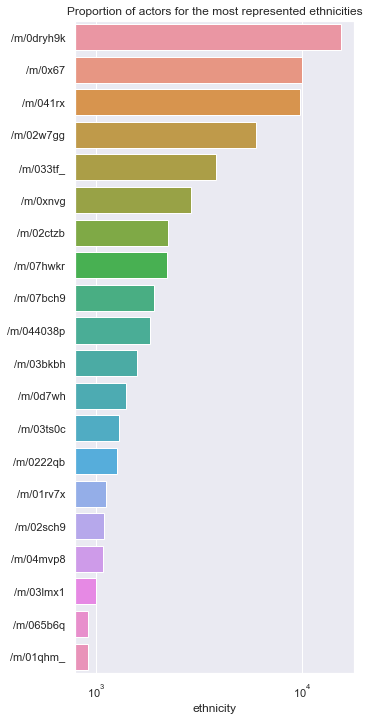

In [183]:
popular_ethn=population_per_ethnicity[0:20]
#sns.set(rc={'figure.figsize':(5,12)})
ax=sns.barplot(x = popular_ethn, y = popular_ethn.index).set(title='Proportion of actors for the most represented ethnicities', xscale='log')

## B. Importation of the movie dataset <a name="subparagraph2"></a>

We are also going to use the file `'movie.metadata'` which we are going to merge with the previous dataframe. This new dataframe will contain in addition several more features, like the countries of the movies and the revenue.

In [184]:
data2 = pd.read_csv(data_folder + 'movie.metadata.tsv', sep='\t', header=None)
def format_attr2(df):
     '''
     Create a new dataframe with all attributes
     formatted according to the character data set'
     :param dataframe: pandas.DataFrame
     :return: new dataframe
     '''
     formatted_df = pd.DataFrame()
     formatted_df['wikipedia_id'] = df[df.columns[0]].astype(int)
     formatted_df['movie_name'] = df[df.columns[2]].astype(str)    
     formatted_df['revenue'] = df[df.columns[4]].astype(int, errors='ignore')
     formatted_df['runtime'] = df[df.columns[5]].astype(int, errors='ignore')
     formatted_df['movie_languages'] = df[df.columns[6]].astype(str)
     formatted_df['movie_countries'] = df[df.columns[7]]
     formatted_df['movie_genres'] = df[df.columns[8]].astype(str)
        
     return formatted_df


movie_data = format_attr2(data2)
movie_data.head()

,wikipedia_id,movie_name,revenue,runtime,movie_languages,movie_countries,movie_genres
0,975900,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,Brun bitter,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,White Of The Eye,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,A Woman in Flames,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


We keep the following features for our first data set:

`wikipedia_id` : Wikipedia movie ID \
`movie_name` :  Name of the movie \
`revenue` :  Box office revenue \
`runtime` : Duration of the movie \
`movie_languages` : Languages of the movie \
`movie_countries` : Differents countries of production  \
`movie_genres` : Genres classification 

## C. Merging the two datasets <a name="subparagraph3"></a>

In [185]:
#keep only the characters with known id
movie_data = movie_data[movie_data['wikipedia_id'].isin(charac_data['wikipedia_id'])]
merged_data = pd.merge(charac_data, movie_data, left_on='wikipedia_id', right_on='wikipedia_id', how = 'left')
merged_data

,wikipedia_id,freebase_movie_id,date,character_name,gender,ethnicity,name,age,freebase_actor_character_id,freebase_actor_id,freebase_character_id,movie_name,revenue,runtime,movie_languages,movie_countries,movie_genres
0,13050320,/m/02z4n3m,1920.0,nan,M,/m/07bch9,Oliver Hardy,NaN,/m/040k1r4,/m/0lh0c,nan,Pals and Pugs,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
1,5555565,/m/0dsbmv,1920.0,nan,F,/m/03vv99,Louise Keaton,13.0,/m/040sm8h,/m/03mdkgk,nan,Convict 13,NaN,25.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/0219x_"": ""Indi..."
2,13050489,/m/02z4n6q,1920.0,nan,M,/m/07bch9,Oliver Hardy,NaN,/m/040k1rq,/m/0lh0c,nan,Springtime,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
3,31709439,/m/0bbr0cd,1920.0,Ruth Sawyer,F,/m/02ctzb,Norma Talmadge,NaN,/m/0n9mrpz,/m/042kxg,/m/0n9mrp8,The Branded Woman,NaN,84.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/07s9rl0"": ""Dra..."
4,7036620,/m/0h1dzd,1920.0,nan,F,/m/03bkbh,Moyna MacGill,NaN,/m/02vbbqd,/m/0h1gw0,nan,Nothing Else Matters,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01t_vv"": ""Comedy-drama""}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101804,30672494,/m/0g9xjv9,2012.0,nan,M,/m/0cqgdq,Rajnikanth,61.0,/m/0gw218j,/m/02wmbg,nan,Rana,NaN,NaN,"{""/m/03k50"": ""Hindi Language"", ""/m/09s02"": ""Te...","{""/m/03rk0"": ""India""}","{""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""}"
101805,32985148,/m/0h533hm,2012.0,Raghu,M,/m/0dryh9k,Jiiva,27.0,/m/0h58g5n,/m/0j46lfy,/m/0h8mh95,Neethaane En Ponvasantham,NaN,NaN,"{""/m/07c9s"": ""Tamil Language""}",{},"{""/m/02l7c8"": ""Romance Film""}"
101806,23690065,/m/0gxz14q,2012.0,nan,F,/m/01rv7x,Anupama Kumar,37.0,/m/0hzw16b,/m/080kws4,nan,Mugamoodi,NaN,NaN,{},{},"{""/m/04pbhw"": ""Superhero movie""}"
101807,35997584,/m/0j_5r7f,2012.0,nan,M,/m/041rx,Eli Roth,40.0,/m/0mzm4dl,/m/058kqy,nan,Aftershock,NaN,90.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/03npn"": ""Horror""}"


Here we get the data merged between character data and movie data.
From this data set, we want to see which country has the most diversity.

# 3. Data overview <a name="paragraph2"></a>

## A. Number of movies over time <a name="subparagraph1"></a>

Let's try to clean the `movie_countries` feature to obtaine a clean array : 

In [186]:
# function to change the movie_countries feature in a array with a list o
def map_to_country(row, pick_one=False):
    vals = list(ast.literal_eval(row.movie_countries).values())
    pick_one = False if not vals else pick_one
    return vals if not pick_one else [vals[0]]

df_country = merged_data.copy()
df_country["movie_countries"] = df_country.apply(lambda x: map_to_country(x, False), axis =1)

df_country.sample(10)

,wikipedia_id,freebase_movie_id,date,character_name,gender,ethnicity,name,age,freebase_actor_character_id,freebase_actor_id,freebase_character_id,movie_name,revenue,runtime,movie_languages,movie_countries,movie_genres
7808,10644609,/m/02ql2kn,1958.0,S.L. Jacobowsky,M,/m/041rx,Danny Kaye,NaN,/m/040h9jm,/m/02h48,/m/0cwv72b,Me and the Colonel,NaN,110.0,"{""/m/04306rv"": ""German Language"", ""/m/02h40lc""...",[United States of America],"{""/m/01z4y"": ""Comedy"", ""/m/01g6gs"": ""Black-and..."
92741,20750885,/m/055fq43,2010.0,nan,M,/m/048sp5,Manoj K. Jayan,NaN,/m/059t_j9,/m/0g9dqx,nan,Bhavani IPS,NaN,NaN,"{""/m/09s02"": ""Telugu language"", ""/m/07c9s"": ""T...",[India],"{""/m/02kdv5l"": ""Action""}"
17396,5585815,/m/0dtv_c,1975.0,nan,M,/m/02y_9mh,Ashok Kumar,63.0,/m/0k0nwx,/m/03f22dp,nan,Mili,NaN,150.0,"{""/m/03k50"": ""Hindi Language""}",[India],"{""/m/07s9rl0"": ""Drama"", ""/m/01chg"": ""Bollywood..."
76468,3615688,/m/09q3hd,2006.0,George Morgan,M,/m/042gtr,Martin Sheen,65.0,/m/04d7vzs,/m/0hvb2,/m/0h0hqng,Bordertown,NaN,112.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","[United States of America, United Kingdom]","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F..."
83555,12224218,/m/02vwh9v,2008.0,nan,M,/m/04lfc70,Erik Palladino,39.0,/m/04dc1nw,/m/079cc1,nan,Hotel California,NaN,101.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F..."
39499,34609492,/m/0j25zjq,1994.0,nan,M,/m/0dryh9k,Balakrishna Nandamuri,34.0,/m/0kwdd9y,/m/06t5x_,nan,Bobbili Simham,NaN,NaN,"{""/m/09s02"": ""Telugu language""}",[India],"{""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""}"
57132,1034728,/m/040684,2001.0,Ms. Madeline,F,/m/03bkbh,Alison Lohman,22.0,/m/0h2n070,/m/053wg3,/m/0h2n073,Delivering Milo,NaN,94.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"{""/m/0hj3n2s"": ""Fantasy Comedy"", ""/m/01z4y"": ""..."
76333,5208126,/m/0d7x5d,2006.0,Krishnakant,M,/m/0dryh9k,Alok Nath,50.0,/m/03jpdwq,/m/0276g40,/m/0h1868b,Vivah,NaN,150.0,"{""/m/03k50"": ""Hindi Language""}",[India],"{""/m/03q4nz"": ""World cinema"", ""/m/04t36"": ""Mus..."
33866,2396115,/m/07946z,1990.0,Madonna,F,/m/0b98sy,Tilda Swinton,29.0,/m/03jsyjl,/m/02f2dn,/m/0h1jqrs,The Garden,NaN,92.0,"{""/m/02h40lc"": ""English Language""}","[United Kingdom, Germany]","{""/m/0hn10"": ""LGBT""}"
13251,6061532,/m/0fn43t,1969.0,nan,M,/m/07bch9,David Carradine,32.0,/m/03lp84m,/m/02p5hf,nan,Young Billy Young,NaN,89.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"{""/m/03btsm8"": ""Action/Adventure"", ""/m/04cb4x""..."


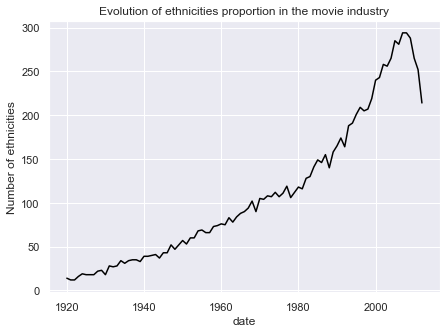

In [187]:


#plot of ethnicity representation from 1900 to 2012

date_charac = df_country.groupby(df_country['date']).apply(lambda x: pd.Series({
        'num_of_ethnicity': x['ethnicity'].nunique(),
        'num_of_movies' : x['movie_name'].nunique()
    }))
plt.figure(figsize=(7,5)) 
plt.plot(date_charac.index, date_charac.num_of_ethnicity, color = 'black')
plt.title('Evolution of ethnicities proportion in the movie industry')
plt.ylabel('Number of ethnicities')
plt.xlabel('date')
plt.show()



We want to check if this evolution is trustworthy or if it is biased by the database that we have.


(It would have been good to do some preliminary analysis whether the representation of ethnicities changes over time. You have the plot “evolution of representation of ethnicity”, but this might be influenced heavily by the database only having old american movies, but not old indian movies (or similar selection biases). You should check for what timeframe you have sufficient data to compare countries and ethnicities.)

First, there are frequently multiple countries in our dataset of movie and character data. To use it in a document categorization, we must create a new dataset that is organized by country. For each row that has two or more movie countries, we simply expand the number of rows by copying all other information and replacing the nation as a single variable.

In [188]:
# First we make a list of all the countries in the data 
countries = []
for values in df_country['movie_countries'] : 
    for value in values: 
        if value not in countries: 
            countries.append(value) 

# Convert the multiple countries in column in a multiple rows (duplication of the row for each the multiples movie_countries)
dft = df_country.explode('movie_countries')
dft= dft.reset_index()
dft.drop_duplicates(subset='freebase_movie_id', keep='first')


# Analysis movie with the revenue and the number of movies for all countries 
data_countries = pd.DataFrame()

data_countries = merged_data.groupby(dft['movie_countries']).apply(lambda x: pd.Series({
         'revenue' : np.nansum(x['revenue']),
         'number_movie': len(x['freebase_movie_id'])
    }))

# sort data with the most movie at the top
data_c =data_countries.sort_values(by='number_movie',ascending=False)
data_c.head(10)

,revenue,number_movie
movie_countries,,
United States of America,1.292356e+12,47417.0
India,4.561447e+11,18827.0
United Kingdom,2.643408e+11,9948.0
France,1.136897e+11,3819.0
Germany,1.195120e+11,3280.0
Canada,8.989223e+10,2741.0
Italy,4.308358e+10,2360.0
Japan,3.394742e+10,1162.0
Australia,3.095528e+10,932.0


In [189]:
#get dataframe with ethnicity name and the group
fname = 'mapping.pickle'
mapping = pickle.load(open(fname,'rb'))

ethn_by_nActors = charac_data['ethnicity'].value_counts()

ethn = pd.DataFrame()
ethn['ID'] = ethn_by_nActors.keys()
ethn['#Actors'] = ethn_by_nActors.values
ethn['Ethnicity'] = ethn_by_nActors.keys().map(mapping)

asian = ['/m/019kn7','/m/01xhh5','/m/03bx0k4','/m/0d2by']
southasian = ['/m/0dryh9k','/m/01rv7x','/m/02sch9','/m/04mvp8','/m/0bpjh3','/m/0cqgdq','/m/09m6hr','/m/0g0x7_','/m/023mqw','/m/0583cz']
black = ['/m/0x67']
latino = ['/m/01g7zj','/m/025rpb0','/m/09k5jvk']
mixed = []
white = ['/m/041rx','/m/02w7gg','/m/033tf_','/m/0xnvg','/m/02ctzb','/m/07hwkr','/m/07bch9','/m/03bkbh','/m/0d7wh','/m/03ts0c','/m/0222qb','/m/03lmx1','/m/065b6q','/m/01qhm_','/m/048z7l','/m/06mvq','/m/0g8_vp','/m/09vc4s','/m/013xrm','/m/06gbnc','/m/07mqps','/m/02g7sp','/m/0g96wd','/m/063k3h','/m/08hpk0','/m/042gtr','/m/09kr66','/m/03ttfc','/m/038723','/m/022dp5','/m/03vv99']
other = []
ethn_groups = {'Asian_ex_Southasian': asian, 'Southasian': southasian, 'Black/Caribbean/African': black, 'Latino': latino, 'Mixed': mixed, 'White': white, 'Other': other}

merged = pd.merge(dft, ethn, left_on='ethnicity', right_on='ID', how = 'left')
merged = merged.drop(['ID','#Actors','runtime'], axis= 1)

aaa = pd.DataFrame(ethn_groups.items(), columns = ['groups','ethnicity'])

# Convert the multiple ethnicity in column in a multiple rows (duplication of the row for each the multiples ethnicity)
ethngr = aaa.explode('ethnicity')
ethngr

#merge with previous dataset
merged = pd.merge(merged, ethngr, left_on='ethnicity', right_on='ethnicity', how = 'left')
merged

,index,wikipedia_id,freebase_movie_id,date,character_name,gender,ethnicity,name,age,freebase_actor_character_id,freebase_actor_id,freebase_character_id,movie_name,revenue,movie_languages,movie_countries,movie_genres,Ethnicity,groups
0,0,13050320,/m/02z4n3m,1920.0,nan,M,/m/07bch9,Oliver Hardy,NaN,/m/040k1r4,/m/0lh0c,nan,Pals and Pugs,NaN,"{""/m/02h40lc"": ""English Language""}",United States of America,"{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",Scottish American,White
1,1,5555565,/m/0dsbmv,1920.0,nan,F,/m/03vv99,Louise Keaton,13.0,/m/040sm8h,/m/03mdkgk,nan,Convict 13,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...",United States of America,"{""/m/06ppq"": ""Silent film"", ""/m/0219x_"": ""Indi...",British Americans,White
2,2,13050489,/m/02z4n6q,1920.0,nan,M,/m/07bch9,Oliver Hardy,NaN,/m/040k1rq,/m/0lh0c,nan,Springtime,NaN,"{""/m/02h40lc"": ""English Language""}",United States of America,"{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",Scottish American,White
3,3,31709439,/m/0bbr0cd,1920.0,Ruth Sawyer,F,/m/02ctzb,Norma Talmadge,NaN,/m/0n9mrpz,/m/042kxg,/m/0n9mrp8,The Branded Woman,NaN,{},United States of America,"{""/m/06ppq"": ""Silent film"", ""/m/07s9rl0"": ""Dra...",white people,White
4,4,7036620,/m/0h1dzd,1920.0,nan,F,/m/03bkbh,Moyna MacGill,NaN,/m/02vbbqd,/m/0h1gw0,nan,Nothing Else Matters,NaN,"{""/m/02h40lc"": ""English Language""}",United Kingdom,"{""/m/01t_vv"": ""Comedy-drama""}",Irish people,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127457,101804,30672494,/m/0g9xjv9,2012.0,nan,M,/m/0cqgdq,Rajnikanth,61.0,/m/0gw218j,/m/02wmbg,nan,Rana,NaN,"{""/m/03k50"": ""Hindi Language"", ""/m/09s02"": ""Te...",India,"{""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""}",Marathi people,Southasian
127458,101805,32985148,/m/0h533hm,2012.0,Raghu,M,/m/0dryh9k,Jiiva,27.0,/m/0h58g5n,/m/0j46lfy,/m/0h8mh95,Neethaane En Ponvasantham,NaN,"{""/m/07c9s"": ""Tamil Language""}",NaN,"{""/m/02l7c8"": ""Romance Film""}",Indians,Southasian
127459,101806,23690065,/m/0gxz14q,2012.0,nan,F,/m/01rv7x,Anupama Kumar,37.0,/m/0hzw16b,/m/080kws4,nan,Mugamoodi,NaN,{},NaN,"{""/m/04pbhw"": ""Superhero movie""}",Tamil,Southasian
127460,101807,35997584,/m/0j_5r7f,2012.0,nan,M,/m/041rx,Eli Roth,40.0,/m/0mzm4dl,/m/058kqy,nan,Aftershock,NaN,"{""/m/02h40lc"": ""English Language""}",United States of America,"{""/m/01jfsb"": ""Thriller"", ""/m/03npn"": ""Horror""}",Jewish people,White


In [190]:
df_usa = merged[merged['movie_countries'] == 'United States of America' ]
df_india = merged[merged['movie_countries'] == 'India' ]

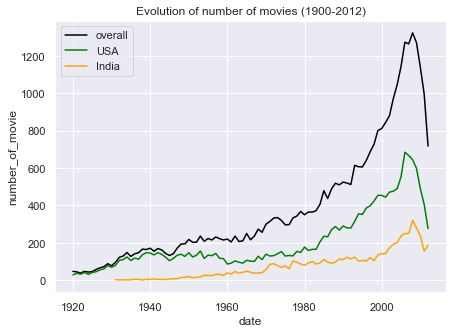

In [191]:
date_charac = merged.groupby(merged['date']).apply(lambda x: pd.Series({
        'num_of_ethnicity': x['ethnicity'].nunique(),
        'num_of_movies' : x['movie_name'].nunique()
    }))

date_charac_usa = df_usa.groupby(df_usa['date']).apply(lambda x: pd.Series({
        'num_of_movies': x['movie_name'].nunique(),
    }))

date_charac_india = df_india.groupby(df_india['date']).apply(lambda x: pd.Series({
        'num_of_movies': x['movie_name'].nunique(),
    }))
plt.figure(figsize=(7,5)) 

plt.plot(date_charac.index, date_charac.num_of_movies, color = 'black', label = 'overall')
plt.plot(date_charac_usa.index, date_charac_usa.num_of_movies, color = 'green', label = 'USA')
plt.plot(date_charac_india.index, date_charac_india.num_of_movies, color = 'orange', label = 'India')

plt.legend(loc="upper left")
plt.title('Evolution of number of movies (1900-2012)')
plt.ylabel('number_of_movie')
plt.xlabel('date')
plt.show()


We should reduce the time for the data. Begin after 1970 ?

In [192]:
df_country_1970 = merged[merged['date'] > 1969]
charac_data_1970 = charac_data[charac_data['date'] > 1969]

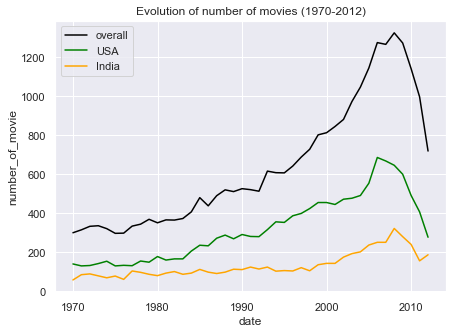

In [193]:
df_usa_1970 = df_country_1970[df_country_1970['movie_countries'] == 'United States of America' ]
df_india_1970 = df_country_1970[df_country_1970['movie_countries'] == 'India' ]

date_charac_1970 = df_country_1970.groupby(df_country_1970['date']).apply(lambda x: pd.Series({
        'num_of_ethnicity': x['ethnicity'].nunique(),
        'num_of_movies' : x['movie_name'].nunique()
    }))

date_charac_usa_1970 = df_usa_1970.groupby(df_usa_1970['date']).apply(lambda x: pd.Series({
        'num_of_movies': x['movie_name'].nunique(),
    }))

date_charac_india_1970 = df_india_1970.groupby(df_india_1970['date']).apply(lambda x: pd.Series({
        'num_of_movies': x['movie_name'].nunique(),
    }))
plt.figure(figsize=(7,5)) 
plt.plot(date_charac_1970.index, date_charac_1970.num_of_movies, color = 'black', label = 'overall')
plt.plot(date_charac_usa_1970.index, date_charac_usa_1970.num_of_movies, color = 'green', label = 'USA')
plt.plot(date_charac_india_1970.index, date_charac_india_1970.num_of_movies, color = 'orange', label = 'India')

plt.legend(loc="upper left")
plt.title('Evolution of number of movies (1970-2012)')
plt.ylabel('number_of_movie')
plt.xlabel('date')
plt.show()


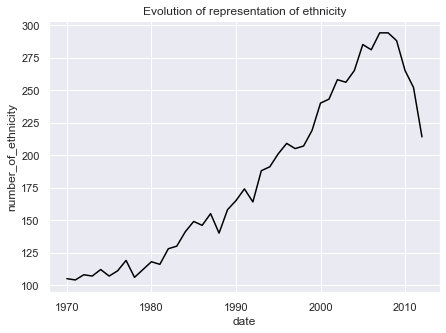

In [194]:

#plot of ethnicity representation from 1970 to 2012

date_charac_1970 = df_country_1970.groupby(df_country_1970['date']).apply(lambda x: pd.Series({
        'num_of_ethnicity': x['ethnicity'].nunique(),
        'num_of_movies' : x['movie_name'].nunique()
    }))
plt.figure(figsize=(7,5)) 
plt.plot(date_charac_1970.index, date_charac_1970.num_of_ethnicity, color = 'black')

plt.title('Evolution of representation of ethnicity')
plt.ylabel('number_of_ethnicity')
plt.xlabel('date')
plt.show()

# 4.How is ethnic diversity represented in each country's film industry?<a name="paragraph3"></a>
Personnal cases for several region (US, China, India, Europe)

Milestone 2 feedback : I don’t understand why you decided to limit your analysis to 9 ethnicities. In the US we might see a shift that films increasingly include black, or asian actors. But there might be similar phenomena in very different markets. China for example, does the representation of Japanese people change? Or in India, how is the distribution between the ethnicities in this country (particularly the representation of Pakistani actors might be interesting).

## China <a name="subparagraph1"></a>

In [195]:
df_china = df_country_1970[df_country_1970['movie_countries']== 'China']
df_china['movie_name'].nunique()

217

Not enought movies to conclude any result. Need to import dataset ?

## USA <a name="subparagraph2"></a>

In [196]:
num_movie_usa = df_usa['movie_name'].nunique()
print("We only have a sample of " + str(num_movie_usa) + " movies produced in the USA from 1970 to 2012.")

We only have a sample of 18159 movies produced in the USA from 1970 to 2012.


In [197]:
#consider only the ethnicity present more than 'x' times. We consider only movies from usa, so we can begin from 1900.
x= 50
top_ethnicity = df_usa['Ethnicity'].value_counts().index
usa_top = df_usa[df_usa['Ethnicity'].isin(top_ethnicity)]
population_per_ethnicity = usa_top['Ethnicity'].value_counts()
ethnicity_array = df_usa['Ethnicity'].unique()

ethn_usa = pd.DataFrame(population_per_ethnicity/len(usa_top))
ethn_usa.head()

,Ethnicity
African Americans,0.163656
Jewish people,0.145507
Irish Americans,0.062060
English people,0.056756
Italian Americans,0.047458


The top 5 ethnicity represent nearly fifty percent of the actors.

In [198]:
#ethnicity groups

population_per_group = df_usa['groups'].value_counts()
population_per_group = pd.DataFrame(population_per_group/len(df_usa))
population_per_group

,groups
White,0.605462
Black/Caribbean/African,0.163656
Latino,0.018976
Asian_ex_Southasian,0.007835
Southasian,0.005786


Whites are clearly more represented, followed by black americans.

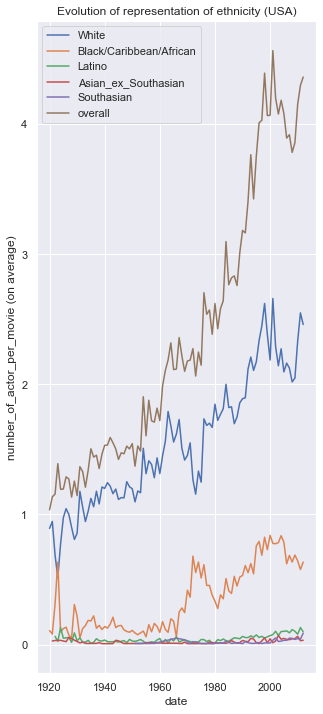

In [199]:
#number of movie per year
usa_year = df_usa.groupby(df_usa['date']).apply(lambda x : pd.Series({
            'num_of_movie' : x['movie_name'].nunique(),
            'num_of_actor_per_year': x['freebase_actor_character_id'].nunique()
        }))
usa_year['rate_overall'] = usa_year.apply(lambda x: x['num_of_actor_per_year'] / x['num_of_movie'], axis =1)

#plot of group of ethnicity representation from 1920 to 2012 in the US
list_df = {}

rates = np.zeros((len(usa_year),len(population_per_group)))
i = 0
for grr in population_per_group.index:
    datagrr = df_usa[df_usa['groups'] == grr]
    date_charac_usa = datagrr.groupby(datagrr['date']).apply(lambda x: pd.Series({
            'num_of_actor' : len(x)
        }))
    date_charac_usa_copy = date_charac_usa
    date_charac_usa = pd.merge(date_charac_usa, usa_year, left_index=True, right_index=True, how = 'left')
    
    date_charac_usa_right = pd.merge(date_charac_usa_copy, usa_year, left_index=True, right_index=True, how = 'right')
    rate = np.array(date_charac_usa_right['num_of_actor']) / np.array(date_charac_usa_right['num_of_movie'])
    rates[:,i] = rate
    date_charac_usa['rate'] = date_charac_usa.apply(lambda x: x['num_of_actor'] / x['num_of_movie'], axis =1)
    list_df[grr] = date_charac_usa
    
    plt.plot(date_charac_usa.index, date_charac_usa.rate, label = grr)
    i += 1

plt.plot(usa_year.index, usa_year.rate_overall , label = 'overall')
plt.title('Evolution of representation of ethnicity (USA)')
plt.legend()
plt.ylabel('number_of_actor_per_movie (on average)')
plt.xlabel('date')
plt.show()

Black and white populations seem to be more and more represented in the movie industry. But the overall number of actor per movie also increase.

In [200]:
labels = np.arange(1920,2011,5).tolist()

df_white = list_df['White']
#df_white = df_white[df_white.index % 5 == 0]
df_white['pourcentage'] = df_white.apply(lambda x: x['rate'] / x['rate_overall'], axis =1)

df_black = list_df['Black/Caribbean/African']
#df_black = df_black[df_black.index % 5 == 0]
df_black['pourcentage'] = df_black.apply(lambda x: x['rate'] / x['rate_overall'], axis =1)

df_latino = list_df['Latino']
#df_latino = df_latino[df_latino.index % 5 == 0]
df_latino['pourcentage'] = df_latino.apply(lambda x: x['rate'] / x['rate_overall'], axis =1)

df_asian = list_df['Asian_ex_Southasian']
#df_asian = df_asian[df_asian.index % 5 == 0]
df_asian['pourcentage'] = df_asian.apply(lambda x: x['rate'] / x['rate_overall'], axis =1)

df_south = list_df['Southasian']
#df_south = df_south[df_south.index % 5 == 0]
df_south['pourcentage'] = df_south.apply(lambda x: x['rate'] / x['rate_overall'], axis =1)

df_test = pd.DataFrame(index=labels)
df_test['white'] = df_white['pourcentage']
df_test['black'] = df_black['pourcentage']
df_test['latino'] = df_latino['pourcentage']
df_test['asian'] = df_asian['pourcentage']
df_test['south'] = df_south['pourcentage']

In [201]:
df_test = df_test.fillna(0)
np_test = np.array(df_test)
df_test

,white,black,latino,asian,south
1920,0.862069,0.103448,0.000000,0.000000,0.000000
1925,0.816327,0.102041,0.040816,0.000000,0.000000
1930,0.746835,0.189873,0.025316,0.000000,0.000000
1935,0.746835,0.120253,0.006329,0.000000,0.000000
1940,0.783784,0.090090,0.022523,0.000000,0.000000
1945,0.783784,0.101351,0.013514,0.020270,0.000000
1950,0.775330,0.070485,0.017621,0.000000,0.000000
1955,0.818605,0.037209,0.004651,0.009302,0.000000
1960,0.763514,0.054054,0.027027,0.006757,0.000000
1965,0.736607,0.084821,0.013393,0.000000,0.000000


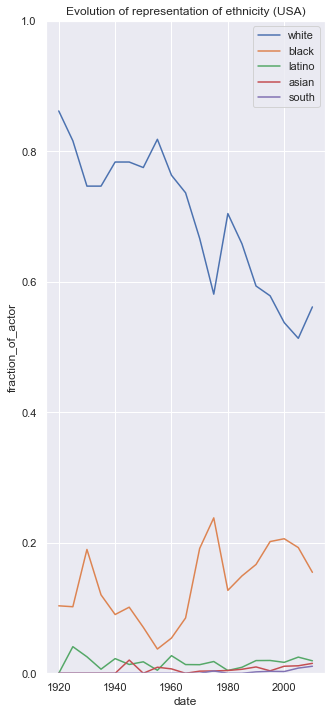

In [202]:
i=0
for grr in df_test.columns:
    plt.plot(df_test.index, df_test[grr], label = grr)
    
plt.title('Evolution of representation of ethnicity (USA)')
plt.legend()
plt.ylim([0, 1])
plt.ylabel('fraction_of_actor')
plt.xlabel('date')
plt.show()

White actor less represented, black actor more represented but not a huge shift. Other seem to be not really represented. Why doesn't add up to 1 ? mixed people not considered. Conclusion : going in a good direction, black ethnicities more represented, mixed too. Asian not that much, considering the huge chinese diaspora. Surprising result.

## India <a name="subparagraph3"></a>

Good amount of movie, we have at least 5400 movies, 22 000 characters, 1200 unique actors.

In [203]:
#top_ethnicity = merged_india['Ethnicity'].value_counts().index
india_top = df_india_1970#[df_india_1970['Ethnicity'].isin(top_ethnicity)]
population_per_ethnicity = df_india_1970['Ethnicity'].value_counts()
ethnicity_array = df_india_1970['Ethnicity'].unique()

ethn_india = pd.DataFrame(population_per_ethnicity/len(india_top))
ethn_india

,Ethnicity
Indians,0.580921
Tamil,0.043248
Punjabis,0.040191
Malayali,0.039741
Marathi people,0.033807
...,...
Italian Australian,0.000045
European Americans,0.000045
Native Hawaiians,0.000045
British Asian,0.000045


First of all, let's look at the presence of pakistanis in the movie industry.

In [204]:
ethn_india[ethn_india.index.isin(['Pakistani','Muslim','Pakistani American'])]

,Ethnicity
Muslim,0.001169
Pakistani American,0.000315


Not really represented. Not surprising considering the relation between the two countries.
If we consider punjabis as pakistanis :

In [205]:
ethn_india[ethn_india.index.isin(['Pakistani','Muslim','Pakistani American','Punjabis'])]

,Ethnicity
Punjabis,0.040191
Muslim,0.001169
Pakistani American,0.000315


Same analysis as for US :

In [206]:
#ethnicity groups

population_per_group = df_india_1970['groups'].value_counts()
population_per_group = pd.DataFrame(population_per_group/len(df_india_1970))
population_per_group

,groups
Southasian,0.828583
White,0.007058
Black/Caribbean/African,0.000989
Latino,0.000090


Nearly only southasian. Clear difference.

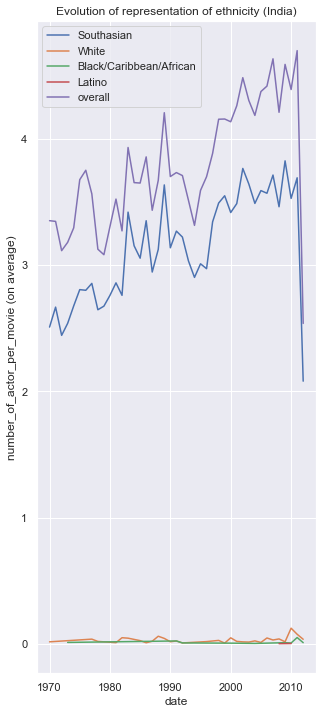

In [207]:
#number of movie per year
india_year = df_india_1970.groupby(df_india_1970['date']).apply(lambda x : pd.Series({
            'num_of_movie' : x['movie_name'].nunique(),
            'num_of_actor_per_year': x['freebase_actor_character_id'].nunique()
        }))
india_year['rate_overall'] = india_year.apply(lambda x: x['num_of_actor_per_year'] / x['num_of_movie'], axis =1)

#plot of group of ethnicity representation from 1970 to 2012 in India
list_df = {}
for grr in population_per_group.index:
    datagrr = df_india_1970[df_india_1970['groups'] == grr]
    date_charac_india = datagrr.groupby(datagrr['date']).apply(lambda x: pd.Series({
            'num_of_actor' : len(x)
        }))
    
    date_charac_india = pd.merge(date_charac_india, india_year, left_index=True, right_index=True, how = 'left')
    date_charac_india['rate'] = date_charac_india.apply(lambda x: x['num_of_actor'] / x['num_of_movie'], axis =1)
    list_df[grr] = date_charac_india

    plt.plot(date_charac_india.index, date_charac_india.rate, label = grr)

plt.plot(india_year.index, india_year.rate_overall , label = 'overall')
plt.title('Evolution of representation of ethnicity (India)')
plt.legend()
plt.ylabel('number_of_actor_per_movie (on average)')
plt.xlabel('date')
plt.show()

Clear that only Southasian population interest us in the case of India.

In [208]:
df_india_south = df_india_1970[df_india_1970['groups']== 'Southasian']
index_south = df_india_south['Ethnicity'].unique()
index_south

array(['Indians', 'Gujarati people', 'Punjabis', 'Kayastha',
       'Kashmiri Pandit', 'Tamil', 'Marathi people', 'Bengali people',
       'Malayali', 'Telugu people'], dtype=object)

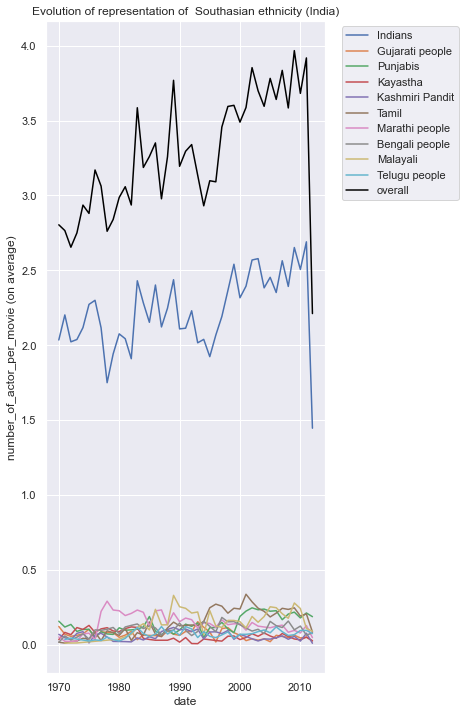

In [209]:
india_year_south = df_india_south.groupby(df_india_south['date']).apply(lambda x : pd.Series({
            'num_of_movie' : x['movie_name'].nunique(),
            'num_of_actor_per_year': x['freebase_actor_character_id'].nunique()
        }))
india_year_south['rate_overall'] = india_year_south.apply(lambda x: x['num_of_actor_per_year'] / x['num_of_movie'], axis =1)
for grr in index_south:
    datagrr = df_india_south[df_india_south['Ethnicity'] == grr]
    date_charac_india_south = datagrr.groupby(datagrr['date']).apply(lambda x: pd.Series({
            'num_of_actor' : len(x)
        }))
    
    date_charac_india_south = pd.merge(date_charac_india_south, india_year, left_index=True, right_index=True, how = 'left')
    date_charac_india_south['rate'] = date_charac_india_south.apply(lambda x: x['num_of_actor'] / x['num_of_movie'], axis =1)

    plt.plot(date_charac_india_south.index, date_charac_india_south.rate, label = grr)

plt.plot(india_year_south.index, india_year_south.rate_overall , color = 'black' ,label = 'overall')
plt.title('Evolution of representation of  Southasian ethnicity (India)')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.ylabel('number_of_actor_per_movie (on average)')
plt.xlabel('date')
plt.show()

Nothing to say apart that the few ethnicities are represented, mainly indian people are.

## Europe <a name="subparagraph4"></a>

In [210]:
europe = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark',
   'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland',
   'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
   'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden']

df_uk = df_country_1970[df_country_1970['movie_countries'] == 'United Kingdom']
df_europe_without_uk = df_country_1970[df_country_1970['movie_countries'].isin(europe)]
df_europe = pd.concat([df_uk,df_europe_without_uk], axis = 0)
len(df_europe)

25238

In [211]:
df_europe['groups'].value_counts()

White                      18236
Black/Caribbean/African     1020
Southasian                   332
Latino                       179
Asian_ex_Southasian          179
Name: groups, dtype: int64

In [212]:
#ethnicity groups

population_per_group = df_europe['groups'].value_counts()
population_per_group = pd.DataFrame(population_per_group/len(df_europe))
population_per_group

,groups
White,0.722561
Black/Caribbean/African,0.040415
Southasian,0.013155
Latino,0.007092
Asian_ex_Southasian,0.007092


In [213]:
europe_top = df_europe[df_europe['Ethnicity'].isin(top_ethnicity)]
population_per_ethnicity = df_europe['Ethnicity'].value_counts()
ethnicity_array = df_europe['Ethnicity'].unique()

ethn_europe = pd.DataFrame(population_per_ethnicity/len(europe_top))
ethn_europe.head(20)

,Ethnicity
English people,0.203929
Jewish people,0.063509
French,0.058618
British people,0.045335
African Americans,0.040563
Irish people,0.035433
False,0.033842
Scottish people,0.033723
Italians,0.032928
Swedes,0.029309


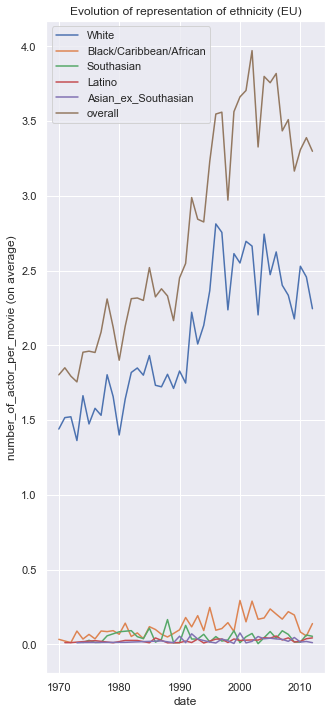

In [214]:
#number of movie per year
europe_year = df_europe.groupby(df_europe['date']).apply(lambda x : pd.Series({
            'num_of_movie' : x['movie_name'].nunique(),
            'num_of_actor_per_year': x['freebase_actor_character_id'].nunique()
        }))
europe_year['rate_overall'] = europe_year.apply(lambda x: x['num_of_actor_per_year'] / x['num_of_movie'], axis =1)

#plot of group of ethnicity representation from 1970 to 2012 in EU
list_df = {}
for grr in population_per_group.index:
    datagrr = df_europe[df_europe['groups'] == grr]
    date_charac_europe = datagrr.groupby(datagrr['date']).apply(lambda x: pd.Series({
            'num_of_actor' : x['freebase_actor_character_id'].nunique()
        }))
    
    date_charac_europe = pd.merge(date_charac_europe, europe_year, left_index=True, right_index=True, how = 'left')
    date_charac_europe['rate'] = date_charac_europe.apply(lambda x: x['num_of_actor'] / x['num_of_movie'], axis =1)
    list_df[grr] = date_charac_europe

    plt.plot(date_charac_europe.index, date_charac_europe.rate, label = grr)

plt.plot(europe_year.index, europe_year.rate_overall , label = 'overall')
plt.title('Evolution of representation of ethnicity (EU)')
plt.legend()
plt.ylabel('number_of_actor_per_movie (on average)')
plt.xlabel('date')
plt.show()


Taking europe as a whole, we can observe a very strong representation of white people. Perhaps better to look at each country indivudually and look at ethnicity and not groups.

In [215]:
df_europe['movie_countries'].value_counts()

United Kingdom    10546
France             4337
Germany            3958
Italy              1815
Spain              1024
Ireland             627
Sweden              605
Netherlands         422
Denmark             387
Belgium             292
Hungary             229
Austria             172
Luxembourg          161
Romania             130
Poland               99
Portugal             99
Finland              95
Greece               80
Bulgaria             43
Croatia              34
Slovakia             30
Lithuania            20
Slovenia             14
Malta                13
Cyprus                6
Name: movie_countries, dtype: int64

Look more closely to UK, France, Germany.

#### UK <a name="subsubparagraph1"></a>

In [216]:
uk_top10 = df_uk['Ethnicity'].value_counts().head(10)
uk_top10

English people       3228
British people        769
Jewish people         667
Scottish people       551
Irish people          441
African Americans     361
False                 304
White British         255
Welsh people          254
white people          241
Name: Ethnicity, dtype: int64

Not really diverse. Almost only europeans.

In [217]:
#ethnicity groups

population_per_group = df_uk['groups'].value_counts()
population_per_group = pd.DataFrame(population_per_group/len(df_uk))
population_per_group

,groups
White,0.775650
Black/Caribbean/African,0.034231
Southasian,0.019059
Latino,0.005120
Asian_ex_Southasian,0.004836


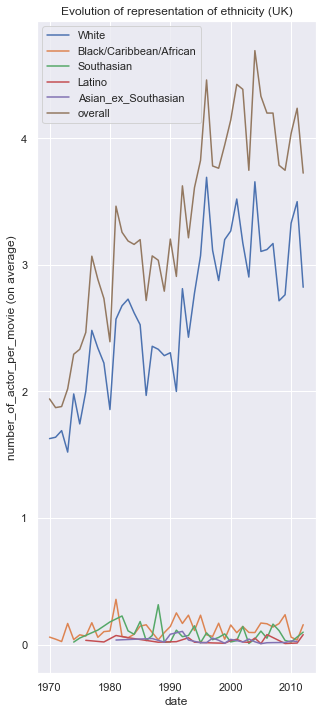

In [218]:
#number of movie per year
uk_year = df_uk.groupby(df_uk['date']).apply(lambda x : pd.Series({
            'num_of_movie' : x['movie_name'].nunique(),
            'num_of_actor_per_year': x['freebase_actor_character_id'].nunique()
        }))
uk_year['rate_overall'] = uk_year.apply(lambda x: x['num_of_actor_per_year'] / x['num_of_movie'], axis =1)

#plot of group of ethnicity representation from 1970 to 2012 in the UK
list_df = {}
for grr in population_per_group.index:
    datagrr = df_uk[df_uk['groups'] == grr]
    date_charac_uk = datagrr.groupby(datagrr['date']).apply(lambda x: pd.Series({
            'num_of_actor' : len(x)
        }))
    
    date_charac_uk = pd.merge(date_charac_uk, uk_year, left_index=True, right_index=True, how = 'left')
    date_charac_uk['rate'] = date_charac_uk.apply(lambda x: x['num_of_actor'] / x['num_of_movie'], axis =1)
    list_df[grr] = date_charac_uk

    plt.plot(date_charac_uk.index, date_charac_uk.rate, label = grr)

plt.plot(uk_year.index, uk_year.rate_overall , label = 'overall')
plt.title('Evolution of representation of ethnicity (UK)')
plt.legend()
plt.ylabel('number_of_actor_per_movie (on average)')
plt.xlabel('date')
plt.show()

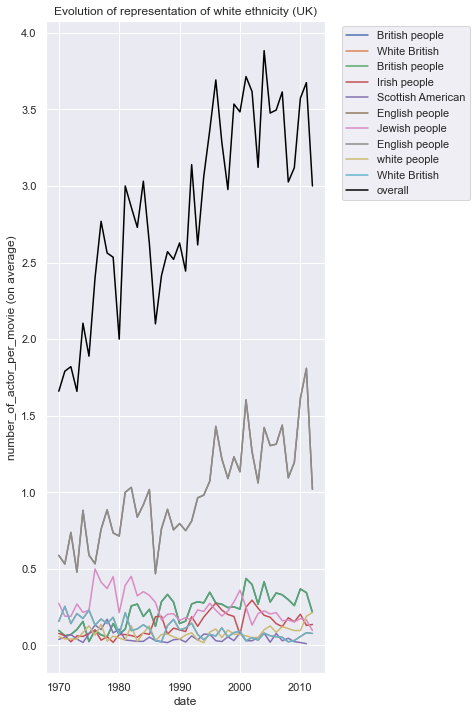

In [219]:
df_uk_white = df_uk[df_uk['groups']== 'White']
index_uk = df_uk_white['Ethnicity'].head(10)


uk_year_white = df_uk_white.groupby(df_uk_white['date']).apply(lambda x : pd.Series({
            'num_of_movie' : x['movie_name'].nunique(),
            'num_of_actor_per_year': x['freebase_actor_character_id'].nunique()
        }))
uk_year_white['rate_overall'] = uk_year_white.apply(lambda x: x['num_of_actor_per_year'] / x['num_of_movie'], axis =1)


for grr in index_uk:
    datagrr = df_uk[df_uk['Ethnicity'] == grr]
    date_charac_uk_white = datagrr.groupby(datagrr['date']).apply(lambda x: pd.Series({
            'num_of_actor' : len(x)
        }))
    
    date_charac_uk_white = pd.merge(date_charac_uk_white, uk_year, left_index=True, right_index=True, how = 'left')
    date_charac_uk_white['rate'] = date_charac_uk_white.apply(lambda x: x['num_of_actor'] / x['num_of_movie'], axis =1)

    plt.plot(date_charac_uk_white.index, date_charac_uk_white.rate, label = grr)

plt.plot(uk_year_white.index, uk_year_white.rate_overall , color = 'black' ,label = 'overall')
plt.title('Evolution of representation of white ethnicity (UK)')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.ylabel('number_of_actor_per_movie (on average)')
plt.xlabel('date')
plt.show()

Ugly graph. Try boxplot

In [220]:
uk_box = pd.DataFrame(df_uk['Ethnicity'].value_counts().head(10))


#### France <a name="subsubparagraph2"></a>

In [221]:
df_france = df_europe[df_europe['movie_countries'] == 'France']
df_france['Ethnicity'].value_counts().head(10)

French               867
English people       511
Jewish people        284
Italians             200
False                171
African Americans    163
Italian Americans    110
British people       104
Germans               99
white people          95
Name: Ethnicity, dtype: int64

Much better representation. Mainly ethnicities of neighbour countries.

#### Germany <a name="subsubparagraph3"></a>

In [222]:
df_germany = df_europe[df_europe['movie_countries'] == 'Germany']
df_germany['Ethnicity'].value_counts().head(10)

English people       533
African Americans    350
Jewish people        323
Germans              236
False                172
Irish Americans      159
Italian Americans    118
white people         107
French               104
British people       104
Name: Ethnicity, dtype: int64

Surprinsingly a lot of African americans. Not a lot of german. A lot of ethnicities represented, once again neighbouring countries but also african representation.

### Top 100 movies US <a name="subparagraph6"></a>

In [223]:
movie_100 = df_country_1970[df_country_1970['revenue'].notna()]
movie_100 = movie_100.sort_values(by= 'revenue', ascending=False)
top_100_movie = movie_100.movie_name.unique()[0:100,]   # get name of top 100
movie_100 = df_country_1970[df_country_1970['movie_name'].isin(top_100_movie)]
movie_100

,index,wikipedia_id,freebase_movie_id,date,character_name,gender,ethnicity,name,age,freebase_actor_character_id,freebase_actor_id,freebase_character_id,movie_name,revenue,movie_languages,movie_countries,movie_genres,Ethnicity,groups
20129,18107,518615,/m/02ktj7,1976.0,Dwan,F,/m/07hwkr,Jessica Lange,27.0,/m/0j_h7s,/m/0hsn_,/m/05lxyht,King Kong,90614445.0,"{""/m/02h40lc"": ""English Language""}",United States of America,"{""/m/0g092b"": ""Monster movie"", ""/m/0jdm8"": ""Re...",white Americans,White
20130,18108,518615,/m/02ktj7,1976.0,King Kong,M,/m/0g8_vp,Peter Cullen,35.0,/m/0h34xh0,/m/03dn9v,/m/04lr_4,King Kong,90614445.0,"{""/m/02h40lc"": ""English Language""}",United States of America,"{""/m/0g092b"": ""Monster movie"", ""/m/0jdm8"": ""Re...",Canadian Americans,White
20314,18263,518615,/m/02ktj7,1976.0,nan,M,/m/041rx,Charles Grodin,41.0,/m/0j_h7m,/m/01gy5k,nan,King Kong,90614445.0,"{""/m/02h40lc"": ""English Language""}",United States of America,"{""/m/0g092b"": ""Monster movie"", ""/m/0jdm8"": ""Re...",Jewish people,White
21184,19025,52549,/m/0dtfn,1977.0,Darth Vader,M,/m/0x67,James Earl Jones,46.0,/m/02nv74t,/m/0f6_x,/m/0f2y0,Star Wars Episode IV: A New Hope,775398007.0,"{""/m/02h40lc"": ""English Language""}",United States of America,"{""/m/06n90"": ""Science Fiction"", ""/m/03k9fj"": ""...",African Americans,Black/Caribbean/African
21207,19046,52549,/m/0dtfn,1977.0,Leia Organa,F,/m/041rx,Carrie Fisher,20.0,/m/0k3r24,/m/01tnbn,/m/0ddqw,Star Wars Episode IV: A New Hope,775398007.0,"{""/m/02h40lc"": ""English Language""}",United States of America,"{""/m/06n90"": ""Science Fiction"", ""/m/03k9fj"": ""...",Jewish people,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127401,101763,31186339,/m/0gkz15s,2012.0,Gale Hawthorne,M,/m/0bbz66j,Liam Hemsworth,22.0,/m/0gw7kv7,/m/04yd0fh,/m/0ds96_p,The Hunger Games,686533290.0,"{""/m/02h40lc"": ""English Language""}",United States of America,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...",Australians,NaN
127402,101764,31186339,/m/0gkz15s,2012.0,Caesar Flickerman,M,/m/0xnvg,Stanley Tucci,51.0,/m/0gw7kw1,/m/02bj6k,/m/0gwc3bn,The Hunger Games,686533290.0,"{""/m/02h40lc"": ""English Language""}",United States of America,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...",Italian Americans,White
127403,101765,31186339,/m/0gkz15s,2012.0,President Snow,M,/m/07bch9,Donald Sutherland,76.0,/m/0gwc391,/m/0ywqc,/m/0dsbx11,The Hunger Games,686533290.0,"{""/m/02h40lc"": ""English Language""}",United States of America,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...",Scottish American,White
127404,101766,31186339,/m/0gkz15s,2012.0,Cinna,M,/m/041rx,Lenny Kravitz,47.0,/m/0gw7kvx,/m/0161sp,/m/0gwc39n,The Hunger Games,686533290.0,"{""/m/02h40lc"": ""English Language""}",United States of America,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...",Jewish people,White


In [224]:
only_movie = movie_100.drop_duplicates(subset='movie_name', keep='first')
only_movie['movie_countries'].value_counts()

United States of America    98
Singapore                    1
Name: movie_countries, dtype: int64

In [225]:
movie_100['Ethnicity'].value_counts()

English people                         373
Jewish people                          137
African Americans                      125
British people                         100
Scottish people                         54
                                      ... 
White Africans of European ancestry      1
Danish Canadians                         1
British Nigerian                         1
Belgians                                 1
Indo Caribbeans                          1
Name: Ethnicity, Length: 126, dtype: int64

In [226]:
movie_100['groups'].value_counts()

White                      1117
Black/Caribbean/African     125
Latino                       18
Southasian                   15
Asian_ex_Southasian          13
Name: groups, dtype: int64

Biased ? only americans movie. Say top 100 of americans movie then. As before, huge representation of white. Lot of ethnicities but not greatly represented. Black seem a bit more represented than other group ethnicities, white excluded.

### Interactive plot <a name="subparagraph7"></a>

In [227]:
import plotly.express as px

df_interactive = merged.groupby(['movie_countries','date','groups']).apply(lambda x: pd.Series({
        'population': len(x),
    }))

coun = ['United States of America','India','France','Germany','United Kingdom']
df_interactive = df_interactive.reset_index()
df_interactive = df_interactive[df_interactive['movie_countries'].isin(coun)]
df_interactive = df_interactive.sort_values(by ='date')

# Add column on lattitude and longitude
# Create a dictionary containing the latitude and longitude of each country
locations = {
    "France": (46.603354, 1.8883335),
    "Germany": (51.16569, 10.451526),
    "United Kingdom": (55.378051, -3.435973),
    "India": (20.593684, 78.96288),
    "United States of America": (37.09024, -95.712891)
}

# Add the latitude and longitude columns to the dataframe
for country, coords in locations.items():
    df_interactive.loc[df_interactive["movie_countries"] == country, "Latitude"] = coords[0]
    df_interactive.loc[df_interactive["movie_countries"] == country, "Longitude"] = coords[1]
df_interactive

,movie_countries,date,groups,population,Latitude,Longitude
659,France,1920.0,White,1,46.603354,1.888334
2853,United States of America,1920.0,Black/Caribbean/African,3,37.090240,-95.712891
2854,United States of America,1920.0,White,25,37.090240,-95.712891
844,Germany,1920.0,White,16,51.165690,10.451526
2608,United Kingdom,1920.0,White,4,55.378051,-3.435973
...,...,...,...,...,...,...
992,Germany,2012.0,White,20,51.165690,10.451526
991,Germany,2012.0,Black/Caribbean/African,2,51.165690,10.451526
990,Germany,2012.0,Asian_ex_Southasian,1,51.165690,10.451526
2852,United Kingdom,2012.0,White,144,55.378051,-3.435973


For the plotly to work correctly and to display every groups of ethnicity, we to have a dataframe for which every ethnicity for each year has a population. We use a country name 'dummy' with latitude and longitude 0.

In [228]:
# Create a list of dates from 1920 to 2012, with 5 entries for each year. Have to do it so that plotly display all groups.
dates = []
for year in range(1920, 2013):
    for i in range(5):
        dates.append(int(year))

# Create a list of dummy movie countries
movie_countries = ['dummy'] * len(dates)

# Create a list of population values (all 1)
population = [1] * len(dates)

# Create a list of latitude and longitude values (all 0)
latitude = [0] * len(dates)
longitude = [0] * len(dates)

# Create a list of groups, with one entry for each date
groups = ['White', 'Black/Caribbean/African', 'Asian_ex_Southasian', 'Latino', 'Southasian'] * len(range(1920, 2013))

# Create the DataFrame
df_dummy = pd.DataFrame({'movie_countries': movie_countries,
                   'date': dates,
                   'groups': groups,
                   'population': population,
                   'Latitude': latitude,
                   'Longitude': longitude})

# Create the DataFrame used for the map
df_interactive_map = pd.concat([df_interactive,df_dummy])
df_interactive_map = df_interactive_map.sort_values(by= 'date')



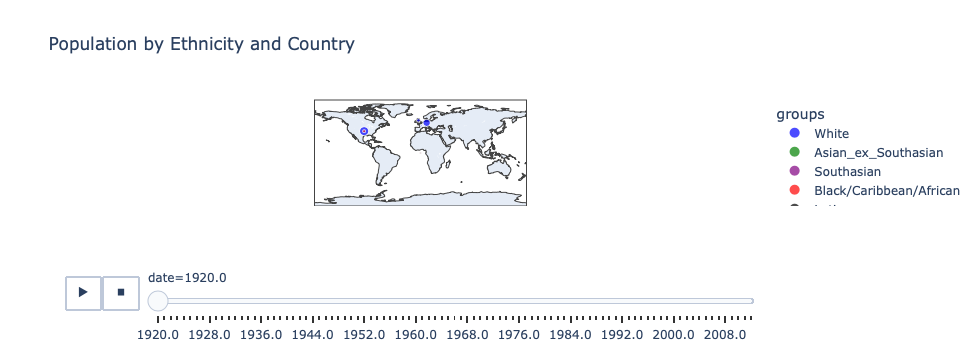

In [229]:
# Create an interactive bubble chart
#fig = px.scatter_geo(df_interactive,lat = "Latitude", lon = "Longitude",locations= 'movie_countries', size="population", color="groups",
#                     hover_name="movie_countries", animation_frame="date",
#                     title="Population by Ethnicity and Country")


fig = px.scatter_geo(
    data_frame=df_interactive_map,  #dataframe
    lat="Latitude",  # The column containing the latitude
    lon="Longitude",  # The column containing the longitude
    size="population",  # The column containing the population
    size_max = 50,
    color='groups',  # The column containing the ethnicity
    color_discrete_map={'White': 'blue', 'Black/Caribbean/African': 'red','Asian_ex_Southasian': 'green','Latino': 'black','Southasian': 'purple' },
    hover_name="movie_countries",  # The column containing the country name
    title="Population by Ethnicity and Country",  # The chart title
    animation_frame="date"  # The column containing the date
)

fig.show()

# 5-Diversity score <a name="paragraph5"></a>

## A-Entropy score <a name="subparagraph1"></a>

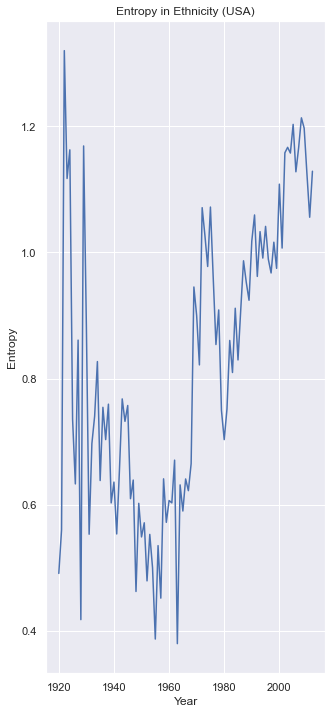

In [230]:
# Plot entropy
rates[np.isnan(rates)] = 0
row_sum = np.sum(rates,1)

np.seterr(divide = 'ignore')
H = np.zeros((len(usa_year)))
for i in range(len(population_per_group)):
    factor = rates[:,i]/row_sum
    log_ = np.log2(factor)
    log_[np.isinf(log_)] = 0
    H = H - factor*log_
np.seterr(divide = 'warn')

plt.plot(usa_year.index,H)
plt.title('Entropy in Ethnicity (USA)')
plt.xlabel('Year')
plt.ylabel('Entropy')
plt.show()

Check why entropy is bigger than one and find reason why it is declining in the beginning of the 20th century.

## B-Simpson index <a name="subparagraph2"></a>

In [231]:
def simpson_index (data) : 
    from collections import Counter

    # Calculate the relative abundance of each data point
    counts = Counter(data)
    abundances = {k: v/len(data) for k, v in counts.items()}
    # Calculate the Simpson diversity index
    simpson_index = 1 - sum(v**2 for v in abundances.values())
    
    return simpson_index 

We will first group all the movies by their wikipedia ID to calculate the diversity score of their actors, then we will make an analysis to see if their is more diversity over time as nowadays diversity representation is big subject we expect to see more diversity now moroever in occidental movies : Europe, USA, Australia...
1. Match the number of actors 
    ```
    First for to be fair we have to match movies by their numbers of actors, as obviously a movie with 14 actors as more chance to have a good diversity than a movie with only two actors. 
    
    ```

2. Match the country
   ```
   Secondly we will match each movie by their countries movies, as some countries have diversity in actors than other (see analysis made earlier). 
    ```
3. Study over time by period of 10 years 
  ```
   Last but not least we will only take some periods and group movies for every 10 years to have enough data so we will begin in 1940 to 2010. 
    ```

### 1-Bootstrap resampling<a name="subsubparagraph1"></a>
 

First the have to change the date to obtain all movies in a 10 years periods in only one category, then we will calculate the diversity score for each movie removing movies with less than 4 actors. 

In [232]:
#replace the last number of the year by 0 to put every years for example 1967 in the period 1960-69
def period (data) : 
    #make a copy
    modified_date = data
    # Set the last number of the year to 0
    modified_date['date'] = modified_date['date'].apply(lambda x: x - (x % 10))
    return modified_date

In [233]:
# remove countries before or after 2010 
period_data = dft[dft.date > 1940]
period_data= period_data[period_data.date < 2011]

# use period function to obtain only period of 10 years
period_data = period (period_data)

In [234]:
#groupby the data by movie and date and calculate the diveristy score for each movie
diversity_movies = period_data.groupby(['wikipedia_id','date'],as_index=False).apply(lambda x: pd.Series({
        'number_of_actors': len(x['freebase_actor_id']),
        'simpson_index' : simpson_index(x['ethnicity'])
    }))

#remove all movies with less than 4 actors
diversity_movies = diversity_movies.loc[diversity_movies["number_of_actors"] >= 4]

In [235]:
#boostrap resampling to calculate the average and the confidence interval for each average value of diversity

### 2-Heatmap of average diversity for each period <a name="subsubparagraph2"></a> 

In [236]:
# Use the heatmap function from the seaborn package
sns.heatmap(result,annot=labels,fmt="",cmap='RdYlGn',linewidths=0.30,ax=ax)

# Display the Pharma Sector Heatmap
plt.show()

NameError: name 'result' is not defined

### 3-Looking at the data and showing significant differences <a name="subsubparagraph3"></a> 

# 6-Correlation between success and actors diversity <a name="paragraph6"></a>

To analyse in more detail the ethnic representation in the movie industry, we can look at the more successful movie and the ethnic diversity in such. First we have to define a successfull movie we have in the dataset two datas that can be used : box-office and the number of movies. 

First we will look at the box-office datas and see if we have enought data. 

In [ ]:
#use of the dataframe created in the first part of the project
df_success = dft.copy()
print("Number of data in the movie dataset {}".format(len(df_success)))
print("Number of data with the revenue {}".format(len(df_success[df_success['revenue']>=0])))

On the all dataset only 28% have a data for the revenue, it is not a lot as it's overall for all the countries on a long period of time. We can look at the distribution and see if it's relevant to work with this data. 

In [ ]:
dft.loc[dft['revenue']>=0, 'movie_countries'].value_counts().head(10)

Looking at the datas, we most of our data are for the USA and is much less for others countries. As it makes more sens to look at the ethnic deiversity in a country we will not use data with less than 1000 data because we will look in these datas as multiple ethnicities that will again dampen the number of data we have. We can select 5 countries with more data and see looking at the ethnic representation if we have cluster on the revenue. 

We prefer to work with another data for the success, as we don't have enought data in the revenu. We will define now the success for a movie as the success of actors playing in this movie. First to implement this we will look at the actors in the dataset and calculate the number of movies for each to define a ranking of successfull actors. 

In [ ]:
#first we will group our dataset by actors 
actor_success = dft.groupby(dft['freebase_actor_id']).apply(lambda x: pd.Series({
        'num_of_movies' : x['movie_name'].nunique(), 
    }))

In [ ]:
actor_success.sort_values(by= 'num_of_movies', ascending=False)

In [ ]:
#plot an histogram to see the proportion of actors that have played in more or less movies
plt.hist(actor_success,bins=100, color = 'powderblue',
            edgecolor = 'green')
plt.xlabel('number of movies')
plt.yscale('log')
plt.ylabel('number of actors in log scale')
plt.title('Proportion of actors by number of movie')
plt.show()

We used a log scale as the distribution look more like a power low distribution. We can see that most actors have played less than 100 movies. We will use an arbitrary threshold and definition of success as the 10% actors with the most movies are the famous one. 

In [ ]:
print("For a threshold of 35 movies played by each actors we have a percentage of {} actors in the dataset".format(len(actor_success.loc[actor_success["num_of_movies"] >= 45])/len(actor_success)*100))


Now that we have famous actors we want to find famous movies in the dataset, a new rule is that we consider a movie successfull if there is more than two famous actors playing in it. 

In [ ]:
#First we have to retrieve these actors and the movies they played in 
top_actors_names = actor_success.loc[actor_success["num_of_movies"] >= 40]

#Retrieve all the movies that have one famous actor playing in it 
dft_success = dft[dft['freebase_actor_id'].isin(top_actors_names.index)]

#We want to drop movies with less than two actors 
dft_success = dft_success.groupby(dft_success['wikipedia_id']).apply(lambda x: pd.Series({
        'num_of_actors' : len(x)
    }))

dft_success = dft_success.loc[dft_success["num_of_actors"] >= 2]

#Now we will obtain a list with the famous movies names we want to consider 
dfamous_movies = dft[dft['wikipedia_id'].isin(dft_success.index)]

In [ ]:
print("For a threshold of less than 1 movie played by each actors we have a percentage of {} actors in the dataset".format(len(actor_success.loc[actor_success["num_of_movies"] <= 27])/len(actor_success)*100))


In [ ]:
#First we have to retrieve these actors and the movies they played in 
actors_names_10 = actor_success.loc[actor_success["num_of_movies"] >= 27]

#Retrieve all the movies name that have an actor with more than 1 movie playing in it
dft_success = dft[dft['freebase_actor_id'].isin(actors_names_10.index)]

#For later we also make the same list with all the non_famous movies 
dnon_famous_movies = dft[~dft['wikipedia_id'].isin(dft_success['wikipedia_id'])]

Now that we obtained the table with our famous movies we will look at some simple analysis like from which countries these movies are, or is there some diversity overall in the datas. A deeper analysis on the diversity with observational studies will be made later on. 

In [ ]:
#firstly drop all duplicates of movies 
famous_movies=dfamous_movies.drop_duplicates(subset='wikipedia_id', keep='first')
non_famous_movies = dnon_famous_movies.drop_duplicates(subset='wikipedia_id', keep='first')

#secondly we will group our dataset by country and count the number of movie by countries
count_movies = famous_movies.groupby(famous_movies['movie_countries'],as_index=False).apply(lambda x: pd.Series({
        'num_of_movies' : len(x['wikipedia_id']),
    }))
#same but for the entire dataframe
count_movies_all = dft.groupby(dft['movie_countries'],as_index=False).apply(lambda x: pd.Series({
        'num_of_movies' : len(x['wikipedia_id']),
    }))
#same but for non famous movies 
count_movies_non = non_famous_movies.groupby(non_famous_movies['movie_countries'],as_index=False).apply(lambda x: pd.Series({
        'num_of_movies' : len(x['wikipedia_id']),
    }))

In [ ]:
print(f"The number of movie in the famous dataset is {len(famous_movies['wikipedia_id'])} while the number of movies for the non famous data set is {len(non_famous_movies['wikipedia_id'])}.")


In [ ]:
print(f"The number of movie in the famous dataset is {count_movies['num_of_movies'].sum()} while the number of movies for the non famous data set is {count_movies_non['num_of_movies'].sum()}.")


In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15, 20))

count_movies_all = count_movies_all.sort_values(by=['num_of_movies'],  ascending=False)
sns.barplot(data=count_movies_all,y='movie_countries',x='num_of_movies', ax = ax[0], palette = "crest")
ax[0].set_title("All movies", fontsize = 17)
ax[0].set_ylabel("Countries", fontsize = 14)
ax[0].set_xscale('log')
ax[0].set_xlabel("Number of movies in log scale", fontsize = 12)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

count_movies = count_movies.sort_values(by=['num_of_movies'],  ascending=False)
sns.barplot(data=count_movies,y='movie_countries',x='num_of_movies', ax = ax[1], palette = "crest")
ax[1].set_title("Famous movies", fontsize = 17)
ax[1].set_ylabel("Countries", fontsize = 14)
ax[1].set_xscale('log')
ax[1].set_xlabel("Number of movies in log scale", fontsize = 12)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

count_movies_non= count_movies_non.sort_values(by=['num_of_movies'],  ascending=False)
sns.barplot(data=count_movies_non,y='movie_countries',x='num_of_movies', ax = ax[2], palette = "crest")
ax[2].set_title("Non famous movies", fontsize = 17)
ax[2].set_ylabel("Countries", fontsize = 14)
ax[2].set_xscale('log')
ax[2].set_xlabel("Number of movies in log scale", fontsize = 12)
ax[2].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)


fig.tight_layout(pad=1.5)
plt.show()

In [ ]:
def small_value (data) : 
    output= data.copy()
    data_lenth = output['num_of_movies'].sum()
    output.loc[(output['num_of_movies']/data_lenth)*100< 2, 'movie_countries'] = 'other'
    output = output.groupby('movie_countries')['num_of_movies'].sum().reset_index()
    return output

We can already tell just looking at the data that we have different data for famous and non famous movies, as checked before we have a similar number of movies for the two dataset but we have different number of countries producing: 90 different countries for the non_famous and 50 for the famous one. Again looking in more detail we can see difference in the movies producing famous or non famous countries. 

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,15))
colors = sns.color_palette('pastel')

ax[0].pie(small_value(count_movies_all)['num_of_movies'],labels= small_value(count_movies_all)['movie_countries'],colors = colors, autopct='%.0f%%')
ax[0].set_title("All movies", fontsize = 17)


ax[1].pie(small_value(count_movies)['num_of_movies'],labels= small_value(count_movies)['movie_countries'], colors = colors, autopct='%.0f%%')
ax[1].set_title("Famous movies", fontsize = 17)

ax[2].pie(small_value(count_movies_non)['num_of_movies'],labels= small_value(count_movies_non)['movie_countries'], colors = colors, autopct='%.0f%%')
ax[2].set_title("Non famous movies", fontsize = 17)

fig.tight_layout(pad=1.5)
plt.show()

As expected the famous movies are more present in US, India and Europe, we also have a good number of data for the Canada. As we have outliers like the United State of America and the distribution is more a distribution we used a log axis for the number of famous movies. Now we will look more into the ethnic diversity in these famous overall and in the main countries producing these movies. 

Here, we load the file which was created in `mapping.ipynb`. It includes a mapping from all ethnicity IDs to human-readable words.

In [ ]:
def mapping (data) : 
    fname = 'mapping.pickle'
    mapping = pickle.load(open(fname,'rb'))
    
    ethn_actors = data['ethnicity'].value_counts()
    ethn= pd.DataFrame()
    ethn['ID'] = ethn_actors.keys()
    ethn['# Actors'] = ethn_actors.values
    ethn['Ethnicity'] = ethn_actors.keys().map(mapping)
    return ethn

In [ ]:
USA_famous = dfamous_movies.loc[dfamous_movies['movie_countries']=='United States of America']
mapping(USA_famous)

In [ ]:
USA_non_famous = dnon_famous_movies.loc[dnon_famous_movies['movie_countries']=='United States of America']
mapping(USA_non_famous)

In [ ]:
def small_ethn (data) : 
    output= data.copy()
    data_lenth = output['# Actors'].sum()
    output.loc[(output['# Actors']/data_lenth)*100< 1, 'Ethnicity'] = 'other'
    output = output.groupby('Ethnicity')['# Actors'].sum().reset_index()
    return output

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,15))
colors = sns.color_palette('pastel')

ax[0].pie(small_ethn(mapping(dfamous_movies))['# Actors'],labels= small_ethn(mapping(dfamous_movies))['Ethnicity'],colors = colors, autopct='%.0f%%')
ax[0].set_title("Famous movies", fontsize = 17)


ax[1].pie(small_ethn(mapping(dnon_famous_movies))['# Actors'],labels= small_ethn(mapping(dnon_famous_movies))['Ethnicity'], colors = colors, autopct='%.0f%%')
ax[1].set_title("Non famous movies", fontsize = 17)


fig.tight_layout(pad=1.5)
plt.show()

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,15))
colors = sns.color_palette('pastel')

ax[0].pie(small_ethn(mapping(USA_famous))['# Actors'],labels= small_ethn(mapping(USA_famous))['Ethnicity'],colors = colors, autopct='%.0f%%')
ax[0].set_title("Famous movies", fontsize = 17)


ax[1].pie(small_ethn(mapping(USA_non_famous))['# Actors'],labels= small_ethn(mapping(USA_non_famous))['Ethnicity'], colors = colors, autopct='%.0f%%')
ax[1].set_title("Non famous movies", fontsize = 17)


fig.tight_layout(pad=1.5)
plt.show()

Now to have a real estimation of the diversity and if there is a difference in ethnic representation for movie with success and without it, we will do an observational study by finding for each successfull movie an non successful one, for that we will look at different criterias. First the country movie has to me matched, secondly the year of production obviouly as to match maybe not the exact same year but we will do it 5 years by 5 years. Lastly the number of actors playing in the movie has to be similar to obtain a significant result. For that we will match cast that have more or less the same number of actors in 2 actors difference. After the matching we will use a linear regression to see if there is a difference in the ethnic diversity by printing a linear table of the diversity score for the two groups (successfull and non successfull movies). 

To understand a score and show diversity, we will calcularte the ethnic diversity with simpson's diversity index [1]. 

[1] McLaughlin, Jacqueline E., Gerald W. McLaughlin, Josetta S. McLaughlin, and Carla Y. White. “Using Simpson’s Diversity Index to Examine Multidimensional Models of Diversity in Health Professions Education.” International Journal of Medical Education 7 (January 3, 2016): 1–5. https://doi.org/10.5116/ijme.565e.1112.

## A-Observationnal study <a name="subparagraph1"></a>

In [ ]:
simpson_bymovie = dfamous_movies.groupby(['wikipedia_id','date','movie_countries'],as_index=False).apply(lambda x: pd.Series({
        'cast': len(x['freebase_actor_id']),
        'simpson_index' : simpson_index(x['ethnicity'])         
    }))

simpson_bynonmovie = dnon_famous_movies.groupby(['wikipedia_id','date','movie_countries'],as_index=False).apply(lambda x: pd.Series({
        'cast': len(x['freebase_actor_id']),
        'simpson_index' : simpson_index(x['ethnicity'])
    }))

#remove movies that have less than two actors 

movie_diverse = simpson_bymovie.loc[simpson_bymovie['cast']>=2]
movie_diverse_non = simpson_bynonmovie.loc[simpson_bynonmovie['cast']>=2]

In [ ]:
#Match the two dataframe for the observationnal study
matched_data =[]

matched_data = pd.merge(movie_diverse,movie_diverse_non, on=['cast','movie_countries','date'], how='left',copy=True, indicator ='Exist')
matched_data['Exist'] = np.where(matched_data.Exist == 'both', True, False)

#drop all row that are not matched
matched_data = matched_data[matched_data['Exist'] == True] 

#just take one matched pair as a movie cannot be mathced multiple time 
matched_data.drop_duplicates(subset=['wikipedia_id_y','wikipedia_id_x'], keep='first')

#show the first values 
matched_data

## B-Linear regression <a name="subparagraph2"></a>

In [ ]:
mat_2 = pd.DataFrame()
mat_1 = pd.DataFrame()
mat_1['simpson_index']= matched_data['simpson_index_x']
mat_1['success']= 1
mat_2['simpson_index']= matched_data['simpson_index_y']
mat_2['success']= 0

import statsmodels.api as sm
import statsmodels.formula.api as smf

mat_data=pd.concat([mat_1, mat_2], axis=0)

mod = smf.ols(formula='simpson_index ~ success',
              data=mat_data)
res = mod.fit()
print(res.summary())

In [ ]:
success_mean = []
success_mean.append(mat_data.loc[mat_data['success']==1,'simpson_index'].mean())
success_mean.append(mat_data.loc[mat_data['success']==0,'simpson_index'].mean())
plt.scatter(mat_data['success'], mat_data['simpson_index'], label='Data', marker='o',c='#88c999')
plt.plot([0,1],success_mean, label='Mean', linestyle='--')
plt.xlabel('Set of data from successfull or not movies')
plt.ylabel('Score for ethnic diveristy from O to 1')
plt.legend(loc='upper right')
plt.title('Linear regression for the two groups')
plt.show()

The intercept 0.4713 is the mean outcome for the simpson index representing diversity for famous movies (x=0). The slope 0.08 is the difference in mean outcomes between the diversity index for x=1 (non_successfull movies) and x=0. It means that for famous movies the diversity of the actors playing in it is superior by 0.08 than for actors playing in non famous movies. Thus, there is a significant difference in diversity between the two groups of movies. To validate this conclusion, we can look at the p value, which is very low. The null hypothesis is rejected: there is a significant difference in diversity for famous or non famous movies.

# 7-Correlation between gender and actors diversity <a name="paragraph6"></a>

## A-Vizualization of gender proportion <a name="subparagraph1"></a>

Gender as ethnicity is a big subject for the society nowedays, we will look at the ethnic diversity and if there is a difference in representation between man and female. First we will just look at a few datas on the gender and how they are represented in the datas we have. 

In [ ]:
dft['gender'].value_counts()
gender=dft.loc[dft['date']<2012]

In [ ]:
female_data = gender.loc[gender['gender']=='F']
male_data = gender.loc[gender['gender']=='M']

print("The dataset is composed at {} percent of men.".format(len(male_data)/(len(female_data)+len(male_data))*100))

In [ ]:
date_actors = gender.groupby(gender['date']).apply(lambda x: pd.Series({
        'num_of_actors': x['freebase_actor_id'].nunique(),
    }))
female = female_data.groupby(female_data['date']).apply(lambda x: pd.Series({
        'num_of_actors': x['freebase_actor_id'].nunique(),
    }))
male = male_data.groupby(male_data['date']).apply(lambda x: pd.Series({
        'num_of_actors': x['freebase_actor_id'].nunique(),
    }))

In [ ]:
fig, ax = plt.subplots()
ax.plot(date_actors.index,date_actors['num_of_actors'], color='indianred', alpha=1.00,label='overall')
ax.plot(female.index,female['num_of_actors'], color='mediumaquamarine', alpha=1.00,label='female')
ax.plot(male.index,male['num_of_actors'], color='sandybrown', alpha=1.00,label='male')
ax.fill_between(date_actors.index, date_actors['num_of_actors'], male['num_of_actors'], color='indianred', alpha=.1)
ax.fill_between(date_actors.index, female['num_of_actors'], male['num_of_actors'], color='sandybrown', alpha=.1)
ax.fill_between(date_actors.index, female['num_of_actors'], 0, color='mediumaquamarine', alpha=.1)
ax.legend(['overall','female','male'])
ax.set_yscale('log')
plt.show()

Looking at the data, overall there is always more men than women actors. To have a better overview of gender representation we will more closely look at each movie and the number of men and women for each cast; we will show over time the proportionality of gender in casts. 

In [ ]:
movie_data = gender.groupby(['wikipedia_id','date'],as_index=False).apply(lambda x: pd.Series({
        'female': len(x[x['gender'] == 'F'])/len(x['gender'])*100,
        'male':  len(x[x['gender'] == 'M'])/len(x['gender'])*100,
    }))

movie_data= movie_data.groupby(movie_data['date']).apply(lambda x: pd.Series({
        'avg_female': x['female'].mean(),
        'avg_male': x['male'].mean(),
    }))

In [ ]:
fig, ax = plt.subplots()
ax.plot(movie_data.index,movie_data['avg_female'], color='mediumaquamarine', alpha=1.00,label='female')
ax.plot(movie_data.index,movie_data['avg_male'], color='sandybrown', alpha=1.00,label='male')
ax.axhline(y = 50, color = 'r', linestyle = 'dashed')
ax.fill_between(movie_data.index, movie_data['avg_male'],movie_data['avg_female'], color='sandybrown', alpha=.1)
ax.fill_between(movie_data.index, movie_data['avg_female'], 0, color='mediumaquamarine', alpha=.1)
ax.legend(['average female','average male','50%'])
plt.show()

We can see a slow increase of female in movie cast, a strange data is represented around 1930, as we look in detail in the data we don't have a lot of data for this date. There is probably an explanation.

## B-T_test <a name="subparagraph2"></a>

# 8-Sentimental analysis <a name="paragraph7"></a>

## A-Score on summary <a name="subparagraph1"></a>

In [ ]:
df_sent = pd.read_csv(data_folder +'plot_summaries.txt', delimiter='\t', names=['wikipedia_id', 'summary'])
df_sent.head()
from textblob import TextBlob
# Create an empty list to store the sentiment scores
sentiment_scores = []

# Loop through the movie summaries and calculate the sentiment score for each summary
for index, row in df_sent.iterrows():
    summary = row['summary']
    sentiment = TextBlob(summary).sentiment.polarity
    sentiment_scores.append(sentiment)

# Add the sentiment scores as a new column in the dataframe
df_sent['sentiment_score'] = sentiment_scores

#merge sentiment analysis df with df containing entropy score. Try to see if there is a correlation.
#Regression analysis or bootstrap mean interval on range of entropy score.

Using the sentimental analysis, we will only look at data movies with more than 4 actors in it. We will compute the diversity percentage and merge with previous `df_sent` and try to look for a relation.

In [ ]:
movie_sent2 = df_country_1970[['wikipedia_id','groups','ethnicity','freebase_actor_id']]
movie_sent = movie_sent2.groupby(['wikipedia_id']).apply(lambda x: pd.Series({
        'number_of_groups': x['groups'].nunique() if x['groups'].nunique() != 0 else x['ethnicity'].nunique(),
        'number_of_actor' : x['freebase_actor_id'].nunique()
    }))
movie_sent = movie_sent[movie_sent['number_of_actor']>4]
movie_sent = movie_sent.sort_values(by = 'number_of_groups')
movie_sent 

In [ ]:
merge_sent = pd.merge(movie_sent, df_sent[['sentiment_score','wikipedia_id']], left_on='wikipedia_id', right_on= 'wikipedia_id', how = 'left')
merge_sent = merge_sent.dropna(axis = 0)
merge_sent['number_of_groups'] = merge_sent['number_of_groups'].astype('float64')

merge_sent

## B-Linear regression <a name="subparagraph2"></a>

In [ ]:
import seaborn as sns
import math
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

mod = smf.ols(formula='sentiment_score ~ number_of_groups', data=merge_sent)
np.random.seed(2)
res = mod.fit()
print(res.summary())

There doesn't seem to be any correlation between the sentiment and the diversity. (at least not a linear relationship).

In [ ]:
plt.scatter(merge_sent['number_of_groups'], merge_sent['sentiment_score'], label='Data', marker='o',c='#88c999')

plt.plot([1,6],[0.0751 - 0.0145*1,0.0751 - 0.0145*6], label='Mean', linestyle='--')
plt.xlabel('Number of groups')
plt.ylabel('Sentiment score from O to 1')
plt.legend(loc='upper right')
plt.title('Linear regression from groups to sentiment score')
plt.show()

The R-squared value of 0.008 indicates that the model explains a small portion of the variance in the dependent variable (sentiment score). The adjusted R-squared value of 0.007 is similar, and indicates that the model accounts for a small amount of the variance in the dependent variable after accounting for the number of variables in the model. The F-statistic and its corresponding p-value of 40.82 and 1.81e-10, respectively, indicate that the model as a whole is statistically significant. We can see that the mean of each groups is nearly the same. We can infer that the diversity of a movie doesn't influence the the sentiment score based on summaries (small variation. decrease by 0.0145 per unit).